#Ice Bed Height Prediction Using Dense Model  

This notebook used the Dense Layer based deep learning model to predict ice bed height using 5 variables ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']. Here both the old data and new interpolated data are used for prediction. The Dense model is trained using training data and tested on testing data and [1201, 1201] grid prediction dataset.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import h5py
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

## Old Data

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/test.csv')
df_pred=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/y_test.csv')
data_1201=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/df_1201.csv')

In [ ]:
df_test

,surf_x,surf_y,surf_vx,surf_vy,surf_elv,surf_dhdt,surf_SMB,track_bed_test_x,track_bed_test_y
0,-220025.0,-1697525.0,-81.467440,0.913897,1862.4003,-0.003780,0.374366,-220038.295520,-1.697568e+06
1,-220025.0,-1697675.0,-81.488320,1.039868,1862.3989,-0.003897,0.374305,-220038.408158,-1.697642e+06
2,-220025.0,-1697825.0,-81.496080,1.172581,1862.3975,-0.004014,0.374243,-220038.646540,-1.697789e+06
3,-220025.0,-1697975.0,-81.490715,1.312036,1862.3961,-0.004131,0.374181,-220038.939782,-1.697936e+06
4,-220025.0,-1698125.0,-81.514725,1.292812,1862.3948,-0.004248,0.374117,-220039.334272,-1.698083e+06
...,...,...,...,...,...,...,...,...,...
235967,-241925.0,-1871675.0,-109.031784,30.579424,1556.2831,-0.412165,-0.018388,-241867.395118,-1.871682e+06
235968,-241925.0,-1871675.0,-109.031784,30.579424,1556.2831,-0.412165,-0.018388,-241879.313090,-1.871664e+06
235969,-241925.0,-1871675.0,-109.031784,30.579424,1556.2831,-0.412165,-0.018388,-241890.904137,-1.871645e+06
235970,-242075.0,-1871375.0,-111.202000,31.286001,1555.5704,-0.418871,-0.016968,-242055.253924,-1.871391e+06


In [ ]:
data_1201

,Unnamed: 0,surf_x,surf_y,surf_vx,surf_vy,surf_dhdt,surf_SMB,surf_elv
0,0,-278075.0,-1697525.0,-117.986570,8.049935,-0.362801,0.102309,1348.6687
1,1,-278075.0,-1697675.0,-118.086580,8.429934,-0.363170,0.100127,1347.2958
2,2,-278075.0,-1697825.0,-118.103740,8.865048,-0.363538,0.098367,1346.9690
3,3,-278075.0,-1697975.0,-118.038060,9.355281,-0.363907,0.096918,1346.1609
4,4,-278075.0,-1698125.0,-117.793236,9.596583,-0.364276,0.095606,1345.8989
...,...,...,...,...,...,...,...,...
1442396,1442396,-98075.0,-1876925.0,-16.739680,7.869811,0.005050,0.332106,2530.5593
1442397,1442397,-98075.0,-1877075.0,-16.679783,7.903055,0.004754,0.332474,2530.5574
1442398,1442398,-98075.0,-1877225.0,-16.616787,7.968928,0.004459,0.332817,2530.5554
1442399,1442399,-98075.0,-1877375.0,-16.527618,8.169706,0.004163,0.333154,2530.5535


In [ ]:
df_test_only_reading=df_test.drop(['track_bed_test_x','track_bed_test_y','surf_x', 'surf_y'],axis=1)
df_train_only_reading=df_train.drop(['track_bed_x','track_bed_y','surf_x', 'surf_y'],axis=1)
test_data_1201=data_1201.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)
test_data_1201_ordered = test_data_1201[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']]

In [ ]:
df_test_only_reading.keys(), df_train_only_reading.keys(), test_data_1201_ordered.keys()

(Index(['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB'], dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB',
        'track_bed_target'],
       dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB'], dtype='object'))

In [ ]:
x1_train=df_train_only_reading.iloc[:,:-1]
y1_train=df_train_only_reading.iloc[:,-1:]
X_test_given=df_test_only_reading.iloc[:,:]
Y_test_given=df_pred.iloc[:,:]

### Plot dataset before normalization:

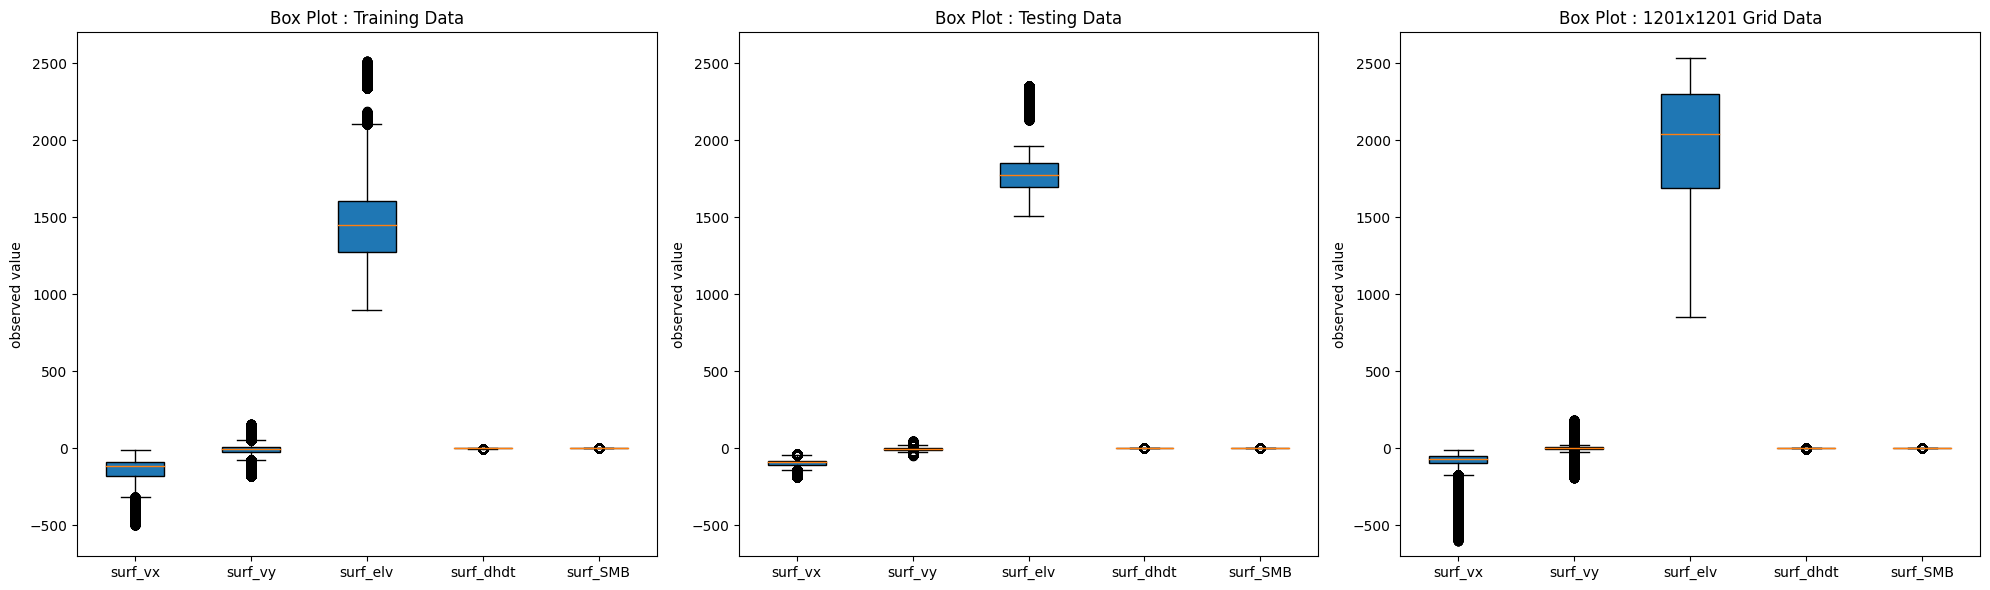

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-700, 2700])
plt.boxplot(x1_train, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-700, 2700])
plt.boxplot(X_test_given, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : Testing Data')


plt.subplot(1, 3, 3)
plt.ylim([-700, 2700])
plt.boxplot(test_data_1201_ordered, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data')

plt.tight_layout()
plt.show()

In [ ]:
x1_train.shape, X_test_given.shape, test_data_1201_ordered.shape

((396734, 5), (235972, 5), (1442401, 5))

In [ ]:
all_X = np.concatenate((x1_train, X_test_given, test_data_1201_ordered), axis=0)
all_X.shape

(2075107, 5)

In [ ]:
y1_train.shape, Y_test_given.shape

((396734, 1), (235972, 1))

In [ ]:
all_Y = np.concatenate((y1_train, Y_test_given), axis=0)
all_Y.shape

(632706, 1)

### Normalize dataset to bring all variables in the range of [0, 1]:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

all_X_nor = scaler_X.fit_transform(all_X)
all_Y_nor = scaler_Y.fit_transform(all_Y)

In [ ]:
all_X_nor.shape, all_Y_nor.shape

((2075107, 5), (632706, 1))

In [ ]:
#seperate the dependent and independent variable for train, test, and 1201 dataset
data_train_X = all_X_nor[0:396734, :]
data_train_Y = all_Y_nor[0:396734, :]
data_test_X = all_X_nor[396734:632706, :]
data_test_Y = all_Y_nor[396734:, :]
data_1201_X = all_X_nor[632706:, :]

### Plot dataset after normalization:

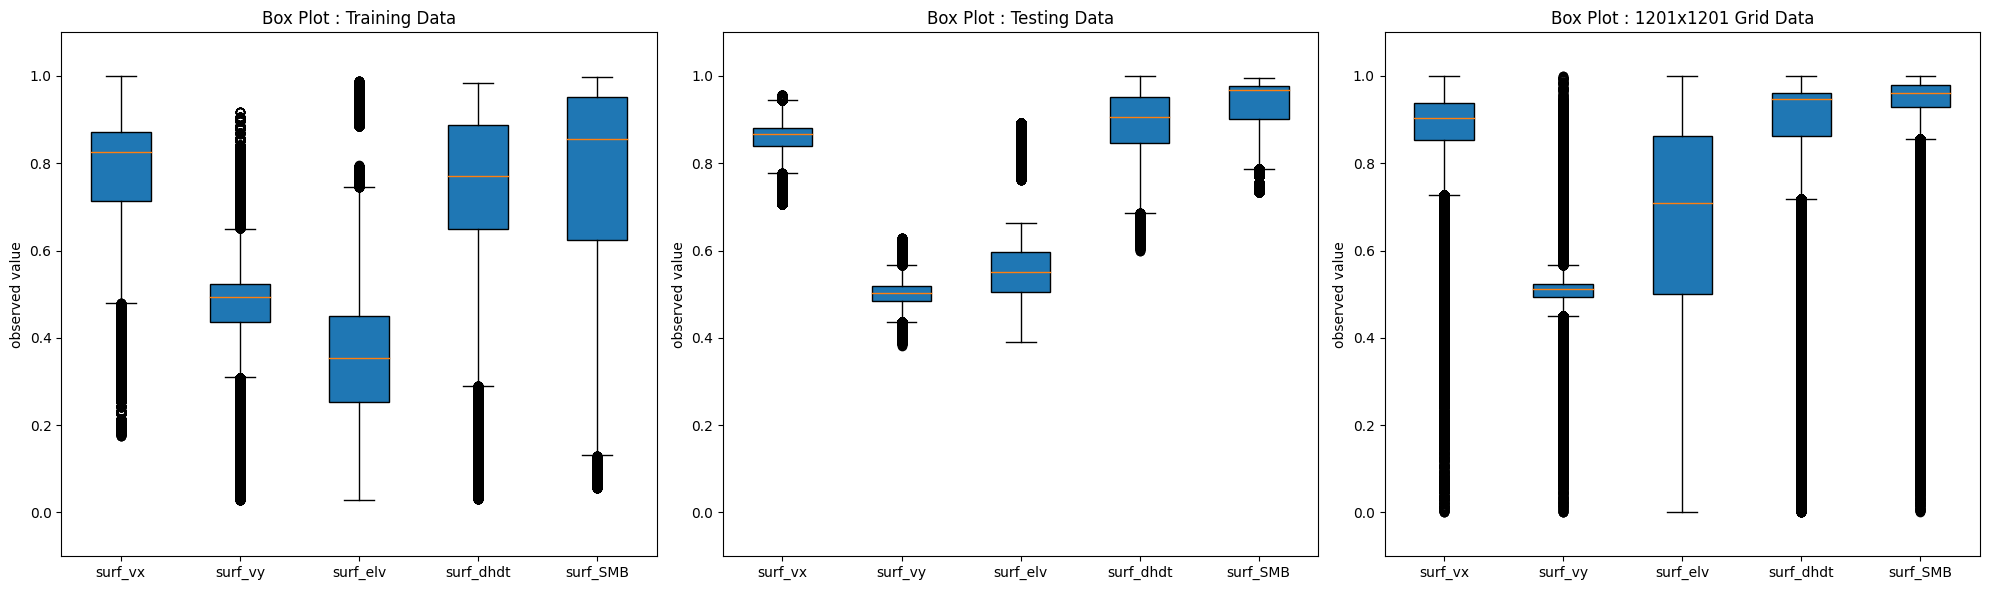

In [ ]:
#pd.DataFrame.from_records(data_train_X).boxplot(), pd.DataFrame.from_records(data_test_X).boxplot(), pd.DataFrame.from_records(data_1201_X).boxplot()

import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-0.1, 1.1])
plt.boxplot(data_train_X, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-0.1, 1.1])
plt.boxplot(data_test_X, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : Testing Data')


plt.subplot(1, 3, 3)
plt.ylim([-0.1, 1.1])
plt.boxplot(data_1201_X, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data')


plt.tight_layout()
plt.show()

### Training model using old data

In [48]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD
import numpy as np

model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(data_train_X.shape[-1],)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="linear"))
#model.compile(loss='mse', optimizer='adam')


In [55]:
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(data_train_X, y=data_train_Y, epochs=200, batch_size=5000, verbose=1, validation_split =0.3, shuffle=True
          )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               768       
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)               

####Prediction of the track bed on training data

In [56]:
y_pred_train = model.predict(data_train_X)

12398/12398 [==============================] - 20s 2ms/step


In [57]:
y_pred_train.shape, data_train_Y.shape

((396734, 1), (396734, 1))

In [58]:
train_Predict_full_range = scaler_Y.inverse_transform(y_pred_train)
data_train_Y_full_range = scaler_Y.inverse_transform(data_train_Y)

In [59]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_train_Y_full_range, train_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_train_Y_full_range, train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_train_Y_full_range, train_Predict_full_range))
print('R^2 Score:', r2_score(data_train_Y_full_range, train_Predict_full_range))

RMSE: 160.8839164111816
RMSE Percentage: 17156.516135996968
RMSE Percentage-1: 771.427296992602
Mean Absolute Error: 135.2872498684366
Mean Absolute Percentage Error: 2.4620432316712333
R^2 Score: 0.288872289536243


In [35]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_train_Y_full_range, train_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_train_Y_full_range, train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_train_Y_full_range, train_Predict_full_range))
print('R^2 Score:', r2_score(data_train_Y_full_range, train_Predict_full_range))

RMSE: 94.36880244137157
RMSE Percentage: 12779.59197075916
RMSE Percentage-1: 710.781619749099
Mean Absolute Error: 72.65147370566571
Mean Absolute Percentage Error: 1.4612833498940438
R^2 Score: 0.755330840467805


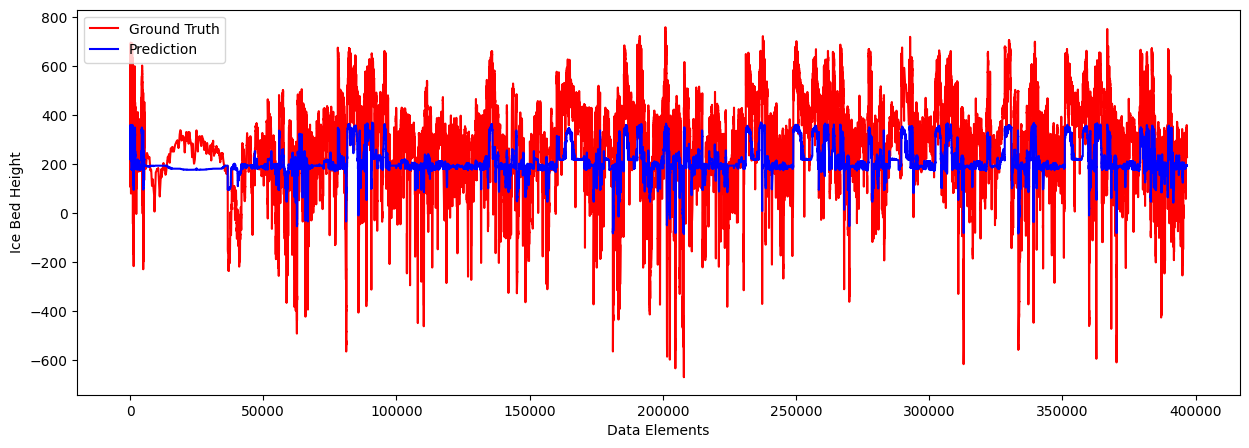

In [60]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(data_train_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(train_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

####Prediction of track bed on test data

In [37]:
y_predict_test = model.predict(data_test_X)

7375/7375 [==============================] - 28s 4ms/step


In [38]:
data_test_Y.shape, y_predict_test.shape

((235972, 1), (235972, 1))

In [39]:
test_Predict_full_range = scaler_Y.inverse_transform(y_predict_test)
data_test_Y_full_range = scaler_Y.inverse_transform(data_test_Y)

In [40]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_test_Y_full_range, test_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_test_Y_full_range, test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_test_Y_full_range, test_Predict_full_range))
print('R^2 Score:', r2_score(data_test_Y_full_range, test_Predict_full_range))

RMSE: 154.22465677839557
RMSE Percentage: 12100.638666108835
RMSE Percentage-1: 214.9734859081341
Mean Absolute Error: 122.86891152662248
Mean Absolute Percentage Error: 1.426525307520423
R^2 Score: -0.12497340297596815


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_test_Y_full_range, test_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_test_Y_full_range, test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_test_Y_full_range, test_Predict_full_range))
print('R^2 Score:', r2_score(data_test_Y_full_range, test_Predict_full_range))

RMSE: 136.26121883893353
RMSE Percentage: 12570.14739040496
RMSE Percentage-1: 117.01100707360523
Mean Absolute Error: 100.70056730675263
Mean Absolute Percentage Error: 1.5419798981734238
R^2 Score: 0.12182884340988742


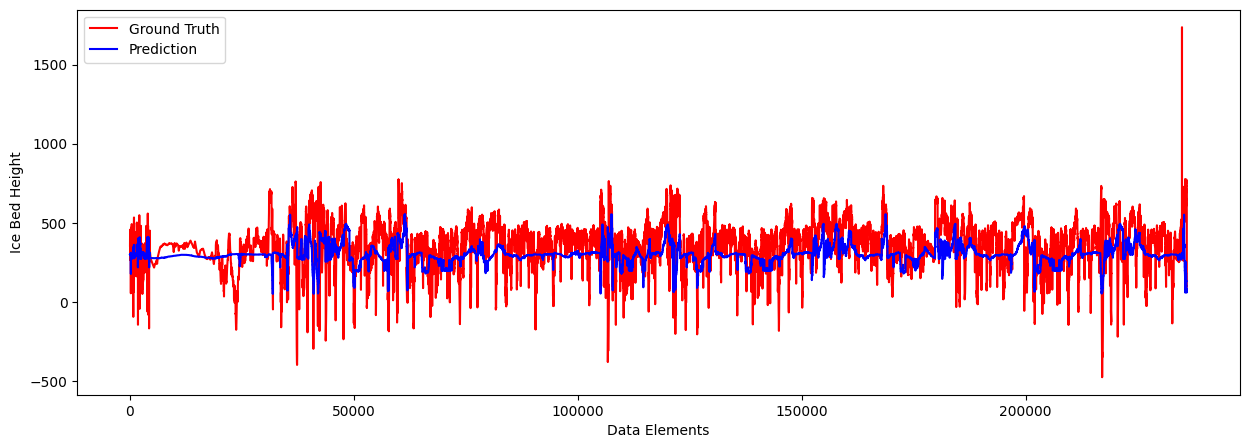

In [41]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(data_test_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(test_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

#### Prediction of ice bed height on 1201x1201 grid data

In [42]:
y_Predict_1201 = model.predict(data_1201_X)

45076/45076 [==============================] - 144s 3ms/step


In [43]:
y_Predict_1201.shape

(1442401, 1)

In [44]:
y_Predict_1201_full = scaler_Y.inverse_transform(y_Predict_1201)

In [45]:
y_Predict_1201_full_flatten=y_Predict_1201_full.flatten()

In [46]:
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)
prediction_on_1201_2D.shape

(1201, 1201)

In [ ]:
new_filename_2 = '/content/drive/MyDrive/Ice-bed_dataset/ice_bed_prediction_1201_Dense_LSTM.h5'

with h5py.File(new_filename_2, 'w') as hf:
    hf.create_dataset("track bed prediction",  data=prediction_on_1201_2D)

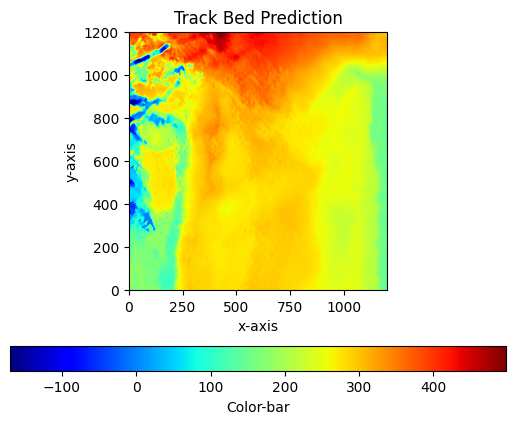

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(prediction_on_1201_2D), cmap="jet")

plt.title('Track Bed Prediction')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.gca().invert_yaxis()
plt.colorbar(label="Color-bar", orientation="horizontal")

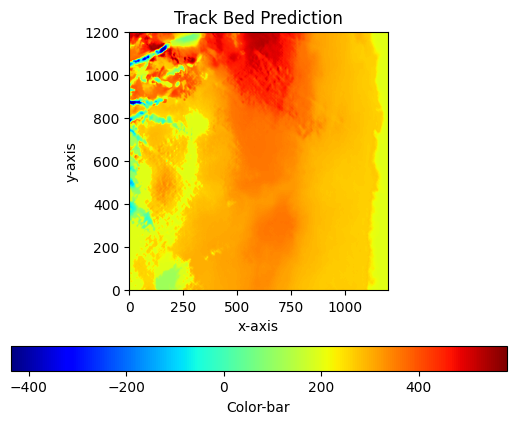

In [47]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(prediction_on_1201_2D), cmap="jet")

plt.title('Track Bed Prediction')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.gca().invert_yaxis()
plt.colorbar(label="Color-bar", orientation="horizontal")

## New Interpolation Data

In [ ]:
n_training_data = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/new_interpolated_track_bed_training.csv')
n_testing_data = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/new_interpotaled_track_bed_testing.csv')
n_df_pred = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/y_test.csv')
n_data_1201 = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/df_1201.csv')
n_test_data_1201 = n_data_1201.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)

In [ ]:
n_training_data

,Unnamed: 0,surf_x,surf_y,track_bed_target,surf_vx,surf_vy,surf_dhdt,surf_SMB,surf_elv
0,0,-206037.406250,-1827384.000,538.235168,-102.379379,2.455286,-0.197761,0.300519,1873.835128
1,1,-205981.171875,-1827518.625,550.491638,-101.973237,2.884405,-0.197749,0.300364,1874.221764
2,2,-205953.109375,-1827586.125,563.800598,-101.784982,2.952367,-0.197750,0.300285,1874.520200
3,3,-205897.078125,-1827720.750,560.530823,-101.493970,2.288839,-0.197765,0.300125,1874.620712
4,4,-205841.328125,-1827855.625,545.708252,-101.271730,1.235018,-0.197797,0.299963,1875.128108
...,...,...,...,...,...,...,...,...,...
396729,396729,-278061.656250,-1720043.625,240.890564,-105.011937,-4.932849,-0.403757,0.144332,1347.292140
396730,396730,-278064.468750,-1720023.125,240.956131,-105.014680,-4.937994,-0.403847,0.144088,1347.204583
396731,396731,-278067.125000,-1720001.375,233.992737,-105.020867,-4.940966,-0.403939,0.143831,1347.069799
396732,396732,-278069.656250,-1719980.875,227.039673,-105.026963,-4.945610,-0.404026,0.143588,1346.941386


In [ ]:
n_testing_data

,Unnamed: 0,surf_x,surf_y,surf_vx,surf_vy,surf_dhdt,surf_SMB,surf_elv
0,0,-220038.295520,-1.697568e+06,-81.469318,1.026504,-0.003840,0.374337,1862.341442
1,1,-220038.408158,-1.697642e+06,-81.479483,1.088446,-0.003898,0.374307,1862.340283
2,2,-220038.646540,-1.697789e+06,-81.490122,1.216577,-0.004015,0.374246,1862.337831
3,3,-220038.939782,-1.697936e+06,-81.488490,1.350560,-0.004132,0.374184,1862.310339
4,4,-220039.334272,-1.698083e+06,-81.506943,1.358371,-0.004249,0.374122,1862.314235
...,...,...,...,...,...,...,...,...
235967,235967,-241867.395118,-1.871682e+06,-109.036689,30.657134,-0.411423,-0.017839,1556.905320
235968,235968,-241879.313090,-1.871664e+06,-109.227077,30.716942,-0.411860,-0.017826,1556.788316
235969,235969,-241890.904137,-1.871645e+06,-109.397180,30.763926,-0.412292,-0.017803,1556.660822
235970,235970,-242055.253924,-1.871391e+06,-111.142185,31.286631,-0.418384,-0.016967,1555.680990


In [ ]:
n_training_data = n_training_data.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)
n_testing_data = n_testing_data.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)

In [ ]:
n_training_data.shape, n_testing_data.shape, n_test_data_1201.shape

((396734, 6), (235972, 5), (1442401, 5))

In [ ]:
n_training_data.keys(), n_testing_data.keys(), n_test_data_1201.keys()

(Index(['track_bed_target', 'surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB',
        'surf_elv'],
       dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv'], dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv'], dtype='object'))

In [ ]:
n_x1_train = n_training_data.iloc[:,1:]
n_y1_train = n_training_data.iloc[:,0:1]
n_X_test_given = n_testing_data.iloc[:,:]
n_Y_test_given = n_df_pred.iloc[:,:]

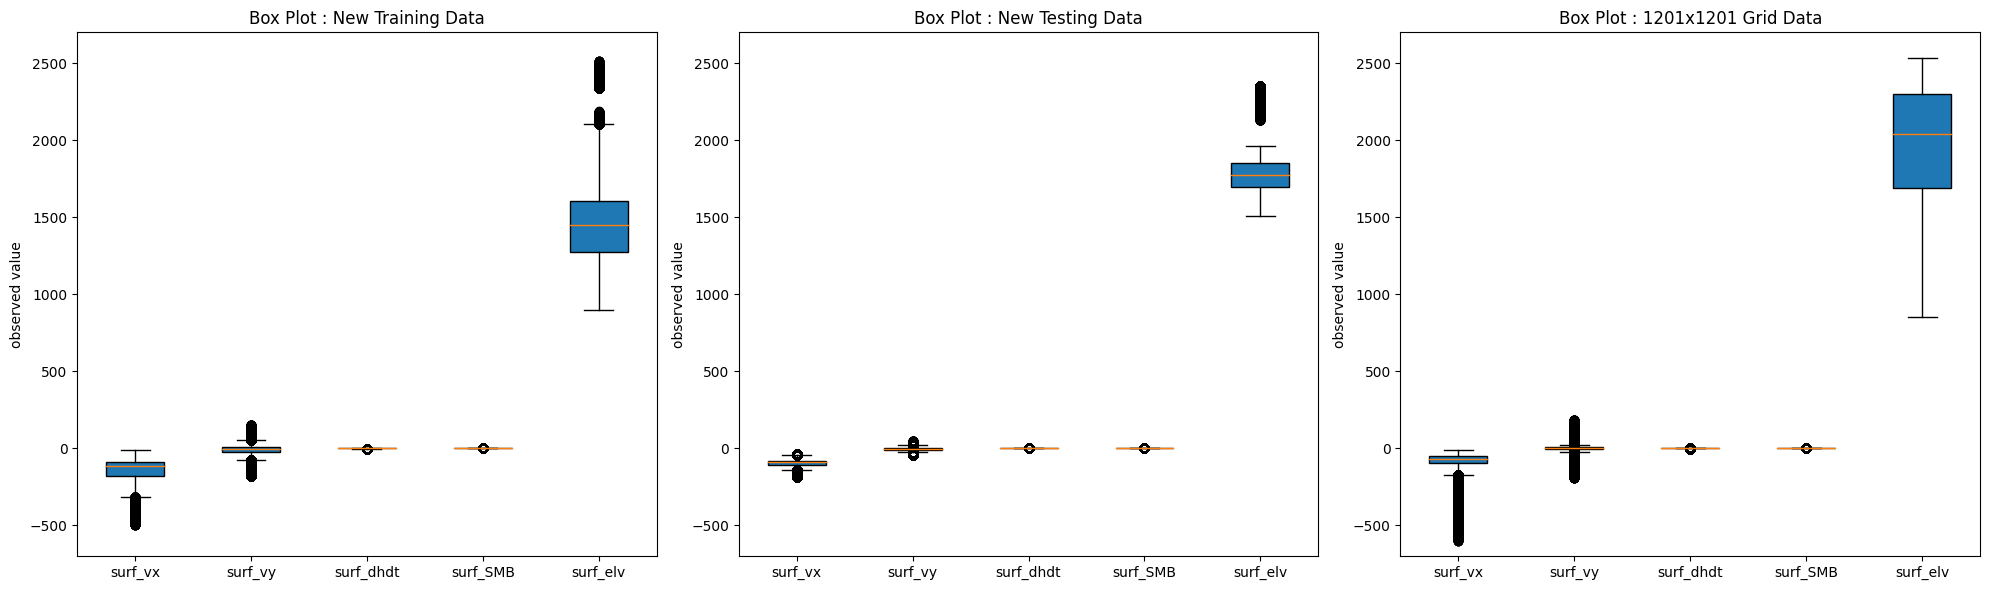

In [ ]:
#n_x1_train.boxplot(), n_X_test_given.boxplot(), n_test_data_1201.boxplot()

import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-700, 2700])
plt.boxplot(n_x1_train, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : New Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-700, 2700])
plt.boxplot(n_X_test_given, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : New Testing Data')


plt.subplot(1, 3, 3)
plt.ylim([-700, 2700])
plt.boxplot(n_test_data_1201, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data')

plt.tight_layout()
plt.show()

In [ ]:
n_x1_train.shape, n_X_test_given.shape, n_test_data_1201.shape

((396734, 5), (235972, 5), (1442401, 5))

In [ ]:
n_all_X = np.concatenate((n_x1_train, n_X_test_given, n_test_data_1201), axis=0)
n_all_X.shape

(2075107, 5)

In [ ]:
n_y1_train.shape, n_Y_test_given.shape

((396734, 1), (235972, 1))

In [ ]:
n_all_Y = np.concatenate((n_y1_train, n_Y_test_given), axis=0)
n_all_Y.shape

(632706, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

n_all_X_nor = scaler_X.fit_transform(n_all_X)
n_all_Y_nor = scaler_Y.fit_transform(n_all_Y)

In [ ]:
n_all_X_nor.shape, n_all_Y_nor.shape

((2075107, 5), (632706, 1))

In [ ]:
#seperate the dependent and independent variable for train, test, and 1201 dataset
n_data_train_X = n_all_X_nor[0:396734, :]
n_data_train_Y = n_all_Y_nor[0:396734, :]
n_data_test_X = n_all_X_nor[396734:632706, :]
n_data_test_Y = n_all_Y_nor[396734:, :]
n_data_1201_X = n_all_X_nor[632706:, :]

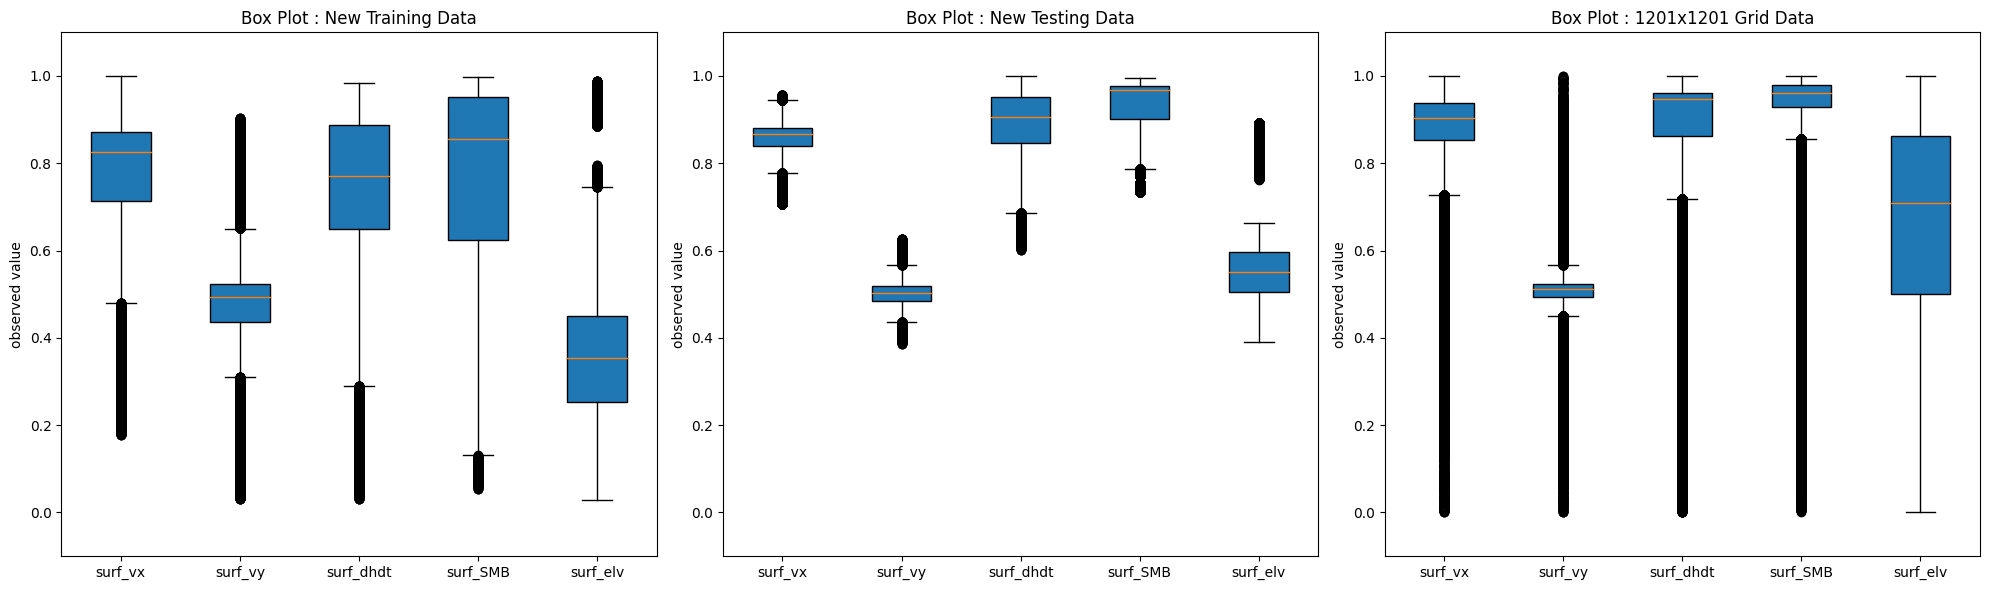

In [ ]:
#pd.DataFrame.from_records(n_data_train_X).boxplot(), pd.DataFrame.from_records(n_data_test_X).boxplot(), pd.DataFrame.from_records(n_data_1201_X).boxplot()

import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-0.1, 1.1])
plt.boxplot(n_data_train_X, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : New Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-0.1, 1.1])
plt.boxplot(n_data_test_X, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : New Testing Data')


plt.subplot(1, 3, 3)
plt.ylim([-0.1, 1.1])
plt.boxplot(n_data_1201_X, vert=True, patch_artist=True, labels=labels)
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data')


plt.tight_layout()
plt.show()



### Training model using new interpolation data

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD
import numpy as np

n_model = Sequential()
n_model.add(Dense(128, activation="relu", input_shape=(n_data_train_X.shape[-1],)))
n_model.add(Dense(64, activation="relu"))
n_model.add(Dropout(0.5))
n_model.add(Dense(32, activation="relu"))
n_model.add(Dense(32, activation="relu"))
n_model.add(Dropout(0.5))
n_model.add(Dense(16, activation="relu"))
n_model.add(Dense(1, activation="linear"))
n_model.compile(loss='mse', optimizer='adam')

In [ ]:
n_model.summary()
n_model.compile(optimizer='adam', loss='mse')
n_model.fit(n_data_train_X, y=n_data_train_Y, epochs=200, batch_size=5000, verbose=1, validation_split =0.3, shuffle=True
          )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               768       
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)               

####Prediction of the track bed on new training data

In [ ]:
n_y_pred_train = n_model.predict(n_data_train_X)

12398/12398 [==============================] - 21s 2ms/step


In [ ]:
n_y_pred_train.shape, n_data_train_Y.shape

((396734, 1), (396734, 1))

In [ ]:
n_train_Predict_full_range = scaler_Y.inverse_transform(n_y_pred_train)
n_data_train_Y_full_range = scaler_Y.inverse_transform(n_data_train_Y)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(n_data_train_Y_full_range, n_train_Predict_full_range)))
print('RMSE Percentage:',rmspe(n_data_train_Y_full_range, n_train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(n_data_train_Y_full_range, n_train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(n_data_train_Y_full_range, n_train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(n_data_train_Y_full_range, n_train_Predict_full_range))
print('R^2 Score:', r2_score(n_data_train_Y_full_range, n_train_Predict_full_range))

RMSE: 129.72762061807245
RMSE Percentage: 10413.197590065585
RMSE Percentage-1: 803.6431099209772
Mean Absolute Error: 104.60990907364533
Mean Absolute Percentage Error: 1.5411965632751379
R^2 Score: 0.5376325553776617


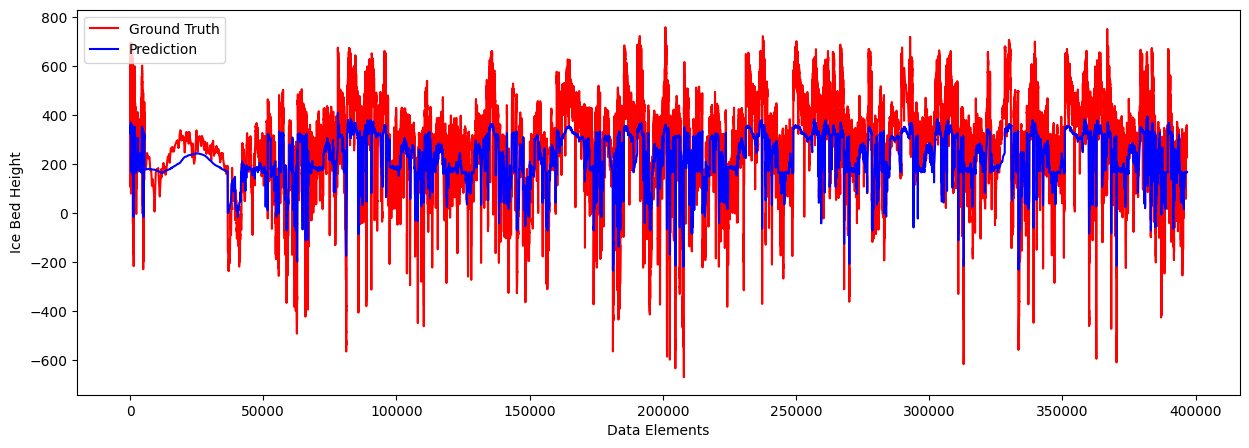

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(n_data_train_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(n_train_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

####Prediction of track bed on new test data

In [ ]:
n_y_predict_test = n_model.predict(n_data_test_X)

7375/7375 [==============================] - 13s 2ms/step


In [ ]:
n_data_test_Y.shape, n_y_predict_test.shape

((235972, 1), (235972, 1))

In [ ]:
n_test_Predict_full_range = scaler_Y.inverse_transform(n_y_predict_test)
n_data_test_Y_full_range = scaler_Y.inverse_transform(n_data_test_Y)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(n_data_test_Y_full_range, n_test_Predict_full_range)))
print('RMSE Percentage:',rmspe(n_data_test_Y_full_range, n_test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(n_data_test_Y_full_range, n_test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(n_data_test_Y_full_range, n_test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(n_data_test_Y_full_range, n_test_Predict_full_range))
print('R^2 Score:', r2_score(n_data_test_Y_full_range, n_test_Predict_full_range))

RMSE: 163.32998871678512
RMSE Percentage: 8310.701187956385
RMSE Percentage-1: 541.3498212051329
Mean Absolute Error: 138.48301014048235
Mean Absolute Percentage Error: 1.2456240386477129
R^2 Score: -0.2617301882062608


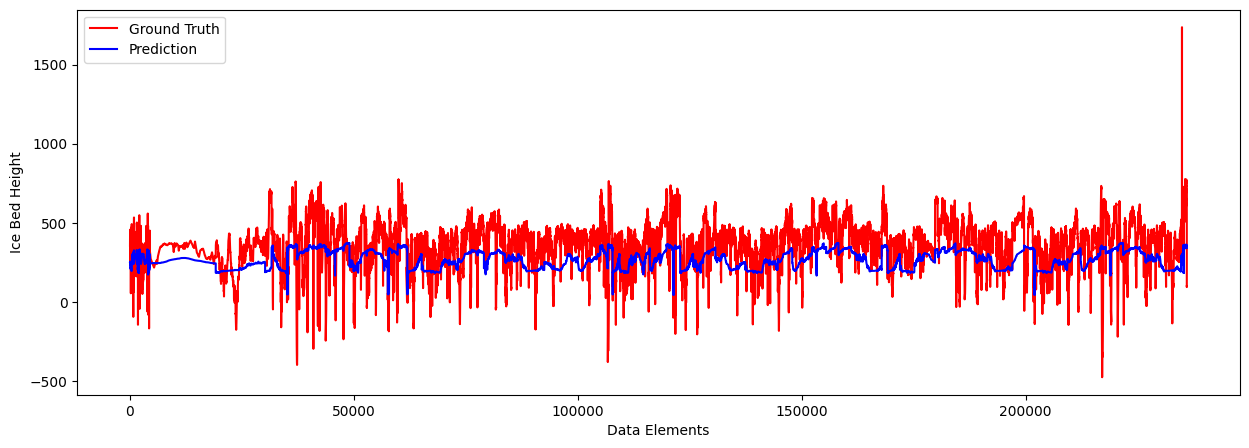

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(n_data_test_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(n_test_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

#### Prediction of ice bed height on 1201x1201 grid data

In [ ]:
n_y_Predict_1201 = n_model.predict(n_data_1201_X)

45076/45076 [==============================] - 71s 2ms/step


In [ ]:
n_y_Predict_1201.shape

(1442401, 1)

In [ ]:
n_y_Predict_1201_full = scaler_Y.inverse_transform(n_y_Predict_1201)

In [ ]:
n_y_Predict_1201_full_flatten=n_y_Predict_1201_full.flatten()

In [ ]:
n_prediction_on_1201_2D=n_y_Predict_1201_full_flatten.reshape(1201,1201)
n_prediction_on_1201_2D.shape

(1201, 1201)

In [ ]:
new_filename_2 = '/content/drive/MyDrive/Ice-bed_dataset/ice_bed_prediction_1201_Dense_LSTM_new.h5'

with h5py.File(new_filename_2, 'w') as hf:
    hf.create_dataset("track bed prediction",  data=n_prediction_on_1201_2D)

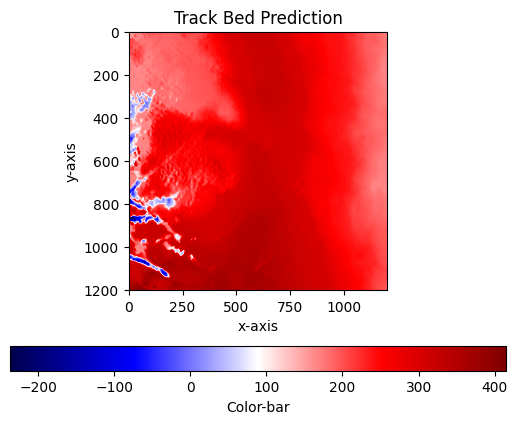

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(n_prediction_on_1201_2D), cmap="seismic")
#plt.imshow(a.squeeze(), cmap="seismic", interpolation="nearest") # new interpolated data
plt.title('Track Bed Prediction')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.colorbar(label="Color-bar", orientation="horizontal")